## Step 0: import
必要なものをインポートする



In [1]:
import os
CODE_DIR = 'psp'

In [2]:
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

sys.path.append(".")
sys.path.append("..")

from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%load_ext autoreload
%autoreload 2

/root/anaconda3/envs/psp_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Select Experiment Type

In [3]:
experiment_type = 'ffhq_encode'

## Step 3: Define Inference Parameters

Below we have a dictionary defining parameters such as the path to the pretrained model to use and the path to the image to perform inference on.
While we provide default values to run this script, feel free to change as needed.

In [4]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

In [5]:
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

We need to verify that the model was downloaded correctly. All of our models should weigh approximately 1.12GB.
Note that if the file weighs several KBs, you most likely encounter a "quota exceeded" error from Google Drive. In that case, you should try downloading the model again after a few hours.

## Step 4: Load Pretrained Model
We assume that you have downloaded all relevant models and placed them in the directory defined by the above dictionary.

In [6]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')

In [7]:
# ckpt['latent_avg']

In [8]:
opts = ckpt['opts']
pprint.pprint(opts)

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}


In [9]:
# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

In [10]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


In [20]:
img_transforms = EXPERIMENT_ARGS['transform']

## 選択

In [21]:
img_dir = 'imgs_align/'
IMAGES3 = []
IMAGES3_NAME = []
for i,file_name in enumerate(os.listdir(img_dir)):
  IMAGES3_NAME.append(os.path.splitext(file_name)[0])
  file_path = img_dir+file_name
  img = Image.open(file_path)
  img = img_transforms(img)
  IMAGES3.append(img)

In [22]:
for i,file in enumerate(os.listdir(img_dir)):
  print(f'{i:2}: {file}')

 0: azuki_default.png
 1: ceo_default.png
 2: check1.png
 3: check2.png
 4: danda_default.png
 5: detective.png
 6: detective_02.png
 7: idPhoto.png
 8: mio_happy.png
 9: mio_shock.png
10: mio_silence.png
11: mio_u.png
12: nanko_default.png
13: ookawa_angry.png
14: ookawa_angry2.png
15: ookawa_default.png
16: ookawa_high.png
17: ookawa_regret.png
18: ookawa_smile.png
19: ookawa_surprised.png
20: pharmacist.png
21: saki.png
22: saki_glasses.png
23: sandy.png
24: takebe_default.png
25: test01.png
26: test01_02.png
27: test01_03.png
28: test01_04.png
29: test02.png
30: woman_default.png
31: yotaka_angry.png
32: yotaka_angry2.png
33: yotaka_bald.png
34: yotaka_bushy.png
35: yotaka_default.png
36: yotaka_gj.png
37: yotaka_smile.png
38: yotaka_smile2.png


## シンプル再構成

In [53]:
%%time
index = [24]
IMAGES_AE = []
IMAGES_AE_NAME = []
RESULTS = []
RESULTS_Q = []
for i in index:
  IMAGES_AE.append(IMAGES3[i])
  IMAGES_AE_NAME.append(IMAGES3_NAME[i])
for i in range(len(IMAGES_AE)):
  w1=net.encoder(IMAGES_AE[i].unsqueeze(0).to("cuda").float())
  w1=w1+ckpt['latent_avg'].to(opts.device).repeat(w1.shape[0],1,1)
  result_image,result_latent=net.decoder([w1],input_is_latent=True,randomize_noise=False,return_latents=True)
  result_image = net.face_pool(result_image)[0]

  output_image = tensor2im(result_image)
  RESULTS.append(output_image)
  # output_image = output_image.quantize()
  # RESULTS_Q.append(output_image)

  dst_dir = 'results/autoencoding/'
  if not os.path.exists(dst_dir): os.makedirs(dst_dir)
  dst_path = f'{dst_dir}{IMAGES_AE_NAME[i]}.png'
  output_image.save(dst_path)

CPU times: user 498 ms, sys: 79.4 ms, total: 577 ms
Wall time: 591 ms


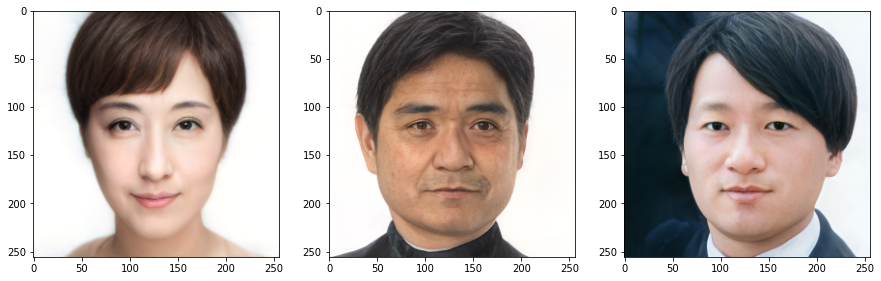

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,len(RESULTS), figsize=(5*len(RESULTS),5))
for i, r in enumerate(RESULTS):
    ax[i].imshow(r)

## transfer

### all

In [64]:
index = [35,37,30]
TRANS = []
TRANS_NAME = []
for i in index:
  TRANS.append(IMAGES3[i])
  TRANS_NAME.append(IMAGES3_NAME[i])

w1=net.encoder(TRANS[0].unsqueeze(0).to("cuda").float())
w1=w1+ckpt['latent_avg'].to(opts.device).repeat(w1.shape[0],1,1)
w2=net.encoder(TRANS[1].unsqueeze(0).to("cuda").float())
w2=w2+ckpt['latent_avg'].to(opts.device).repeat(w2.shape[0],1,1)
w3=net.encoder(TRANS[2].unsqueeze(0).to("cuda").float())
w3=w3+ckpt['latent_avg'].to(opts.device).repeat(w3.shape[0],1,1)
w4 = w3 + (w2-w1)

result_image,result_latent=net.decoder([w4],input_is_latent=True,randomize_noise=False,return_latents=True)
result_image = net.face_pool(result_image)[0]

output_image = tensor2im(result_image)
output_image = output_image.quantize()

dst_dir = 'results/transfer/all/'
if not os.path.exists(dst_dir): os.makedirs(dst_dir)
dst_path = f'{dst_dir}{TRANS_NAME[0]}2{TRANS_NAME[1]}-trans-{TRANS_NAME[2]}.png'
output_image.save(dst_path)